<a href="https://colab.research.google.com/github/Jathurshan0330/Cross-Modal-Transformer/blob/master/Interpret_script_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clone Github

In [ ]:
!git clone https://github.com/Jathurshan0330/Cross-Modal-Transformer.git


Cloning into 'Cross-Modal-Transformer'...
remote: Enumerating objects: 416, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 416 (delta 74), reused 12 (delta 6), pack-reused 292
Receiving objects: 100% (416/416), 100.59 MiB | 13.29 MiB/s, done.
Resolving deltas: 100% (167/167), done.


In [ ]:
cd  /content/Cross-Modal-Transformer

/content/Cross-Modal-Transformer


## Install Requirements 

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install h5py 
!pip install einops
!pip install mne
!pip install gdown

#Select Data using mne

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import mne
from mne.datasets.sleep_physionet.age import fetch_data
from data_preparations.epoch_func import signal_extract

import torch
from torchvision import transforms, datasets
from torch.utils import data
from torch.utils.data import Dataset, DataLoader


# ignore_data = [[13,2],[36,1],[39,1],[39,2],[52,1],[68,1],[68,2], [69,1],[69,2],[78,1],[78,2],[79,1],[79,2]]
subject_no = [38]   ### Include the No of subject of interest in Sleepedf Dataset.   Use [38] - SC4381 to reproduce Fig 6 in the revised paper
days        = [1]   ### Include the day of the recording. Use [1] to reproduce Fig 6 in the revised paper

In [5]:
# Extract dataset and convert it to the suitable format to feed to the model
eeg1_1, labels_1, len_1, eeg1_m1, eeg1_std1 = signal_extract(subject_no, days, channel = 'eeg1', filter = True, freq = [0.2,40])
eog_1, _, len_1, eog_m1, eog_std1 = signal_extract(subject_no, days, channel = 'eog', filter = True, freq = [0.2,40])


print("PRINT",eeg1_1.shape, labels_1.shape, len_1.shape, eeg1_m1.shape, eeg1_std1.shape)
print("PRINT",eog_1.shape, len_1.shape, eog_m1.shape, eog_std1.shape)


Using default location ~/mne_data for PHYSIONET_SLEEP...
['C:\\Users\\Tian_Yumi\\mne_data\\physionet-sleep-data\\SC4381F0-PSG.edf', 'C:\\Users\\Tian_Yumi\\mne_data\\physionet-sleep-data\\SC4381FC-Hypnogram.edf']
Extracting EDF parameters from C:\Users\Tian_Yumi\mne_data\physionet-sleep-data\SC4381F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8249999  =      0.000 ... 82499.990 secs...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passb

D:\AIGC\Cross-Modal-Transformer\data_preparations\epoch_func.py:185: RuntimeWarning: No matching events found for Sleep stage 4 (event id 4)
  epochs_data = mne.Epochs(raw = sleep_signals, events = events,


0 bad epochs dropped
Using default location ~/mne_data for PHYSIONET_SLEEP...
['C:\\Users\\Tian_Yumi\\mne_data\\physionet-sleep-data\\SC4381F0-PSG.edf', 'C:\\Users\\Tian_Yumi\\mne_data\\physionet-sleep-data\\SC4381FC-Hypnogram.edf']
Extracting EDF parameters from C:\Users\Tian_Yumi\mne_data\physionet-sleep-data\SC4381F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8249999  =      0.000 ... 82499.990 secs...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0

D:\AIGC\Cross-Modal-Transformer\data_preparations\epoch_func.py:185: RuntimeWarning: No matching events found for Sleep stage 4 (event id 4)
  epochs_data = mne.Epochs(raw = sleep_signals, events = events,


0 bad epochs dropped
PRINT (1776, 1, 3000) (1776,) (1,) (1776,) (1776,)
PRINT (1776, 1, 3000) (1,) (1776,) (1776,)


In [5]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("decive: ",device)

class SleepEDF_Seq_MultiChan_Dataset_Inference(Dataset):
    def __init__(self, eeg_file, eog_file, label_file, device, mean_eeg_l = None, sd_eeg_l = None, 
                 mean_eog_l = None, sd_eog_l = None, mean_eeg2_l = None, sd_eeg2_l = None,transform=None, 
                 target_transform=None, sub_wise_norm = False, num_seq = 5):
        """
      
        """
        # Get the data
       
        self.eeg = eeg_file
        self.eog = eog_file
        self.labels = label_file

        self.labels = torch.from_numpy(self.labels)
        

        bin_labels = np.bincount(self.labels)
        print(f"Labels count: {bin_labels}")
        print(f"Shape of EEG : {self.eeg.shape} , EOG : {self.eog.shape}")#, EMG: {self.eeg2.shape}")
        print(f"Shape of Labels : {self.labels.shape}")

        if sub_wise_norm == True:
          print(f"Reading Subject wise mean and sd")
          
          self.mean_eeg  = mean_eeg_l
          self.sd_eeg = sd_eeg_l
          self.mean_eog  = mean_eog_l
          self.sd_eog = sd_eog_l
            

        self.sub_wise_norm = sub_wise_norm
        self.device = device
        self.transform = transform
        self.target_transform = target_transform
        self.num_seq = num_seq

    def __len__(self):
        return len(self.labels) - self.num_seq

    def __getitem__(self, idx):
        eeg_data = self.eeg[idx:idx+self.num_seq].squeeze()   
        eog_data = self.eog[idx:idx+self.num_seq].squeeze() 
        label = self.labels[idx:idx+self.num_seq,]   


        if self.sub_wise_norm ==True:
          eeg_data = (eeg_data - self.mean_eeg[idx]) / self.sd_eeg[idx]
          eog_data = (eog_data - self.mean_eog[idx]) / self.sd_eog[idx]
        elif self.mean and self.sd:
          eeg_data = (eeg_data-self.mean[0])/self.sd[0]
          eog_data = (eog_data-self.mean[1])/self.sd[1]
        if self.transform:
            eeg_data = self.transform(eeg_data)
            eog_data = self.transform(eog_data)
        if self.target_transform:
            label = self.target_transform(label)
        return eeg_data, eog_data, label



cuda


In [6]:
num_seq = 15
print(eeg1_1.shape, labels_1.shape, len_1.shape, eeg1_m1.shape, eeg1_std1.shape)
print(eog_1.shape, len_1.shape, eog_m1.shape, eog_std1.shape)

infer_dataset = SleepEDF_Seq_MultiChan_Dataset_Inference(eeg_file = eeg1_1 ,
                                         eog_file = eog_1, 
                                         label_file = labels_1, 
                                         device = device, mean_eeg_l = eeg1_m1, sd_eeg_l = eeg1_std1,
                                         mean_eog_l = eog_m1, sd_eog_l = eog_std1,
                                         sub_wise_norm = True, num_seq = num_seq,
                                         transform=transforms.Compose([
                                               transforms.ToTensor()
                                                ]) )

(1776, 1, 3000) (1776,) (1,) (1776,) (1776,)
(1776, 1, 3000) (1,) (1776,) (1776,)
Labels count: [893  95 612  16 160]
Shape of EEG : (1776, 1, 3000) , EOG : (1776, 1, 3000)
Shape of Labels : torch.Size([1776])
Reading Subject wise mean and sd


In [7]:
infer_data_loader = data.DataLoader(infer_dataset, batch_size = 1, shuffle = False)#16
len(infer_data_loader)

1761

EEG batch shape: torch.Size([1, 1, 15, 3000])
EOG batch shape: torch.Size([1, 1, 15, 3000])
Labels batch shape: torch.Size([1, 15])
torch.Size([15, 3000])


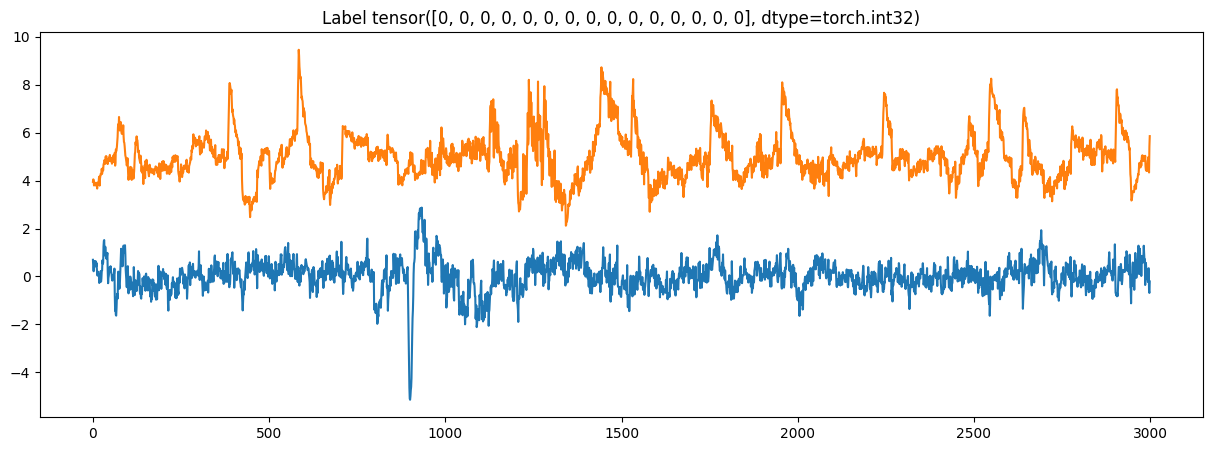

In [8]:
eeg_data, eog_data, label = next(iter(infer_data_loader))
print(f"EEG batch shape: {eeg_data.size()}")
print(f"EOG batch shape: {eog_data.size()}")
# print(f"EMG batch shape: {eeg2_data.size()}")
print(f"Labels batch shape: {label.size()}")

eeg_data_temp = eeg_data[0].squeeze()#(0)
eog_data_temp = eog_data[0].squeeze()#(0)

print(eeg_data_temp.shape)

t = np.arange(0,30,1/100)
plt.figure(figsize = (15,5))
plt.plot(eeg_data_temp[0].squeeze())
plt.plot(eog_data_temp[0].squeeze()+5)
plt.title(f"表格 {label[0].squeeze()}")
plt.show()




#Load Model

In [19]:
from models.sequence_cmt import Seq_Cross_Transformer_Network #as Seq_Cross_Transformer_Network
from models.sequence_cmt import Epoch_Cross_Transformer
from models.model_blocks import PositionalEncoding, Window_Embedding, Intra_modal_atten, Cross_modal_atten, Feed_forward


In [18]:
!gdown 1Y6yPH8XyVLTVY0Wbp8o6qcDWAv9n_NPG 

^C


Downloading...
From: https://drive.google.com/uc?id=1Y6yPH8XyVLTVY0Wbp8o6qcDWAv9n_NPG
To: D:\AIGC\Cross-Modal-Transformer\checkpoint_model_best_acc.pth.tar

  0%|          | 0.00/93.7M [00:00<?, ?B/s]
  1%|          | 524k/93.7M [00:00<00:33, 2.77MB/s]
  2%|▏         | 1.57M/93.7M [00:00<00:16, 5.47MB/s]
  3%|▎         | 3.15M/93.7M [00:00<00:11, 7.97MB/s]
  4%|▍         | 4.19M/93.7M [00:00<00:19, 4.59MB/s]
  6%|▌         | 5.24M/93.7M [00:01<00:27, 3.23MB/s]
  6%|▌         | 5.77M/93.7M [00:01<00:26, 3.28MB/s]
  7%|▋         | 6.29M/93.7M [00:01<00:28, 3.03MB/s]
  7%|▋         | 6.82M/93.7M [00:01<00:30, 2.83MB/s]
  8%|▊         | 7.34M/93.7M [00:02<00:30, 2.80MB/s]
  8%|▊         | 7.86M/93.7M [00:02<00:33, 2.55MB/s]
  9%|▉         | 8.39M/93.7M [00:02<00:34, 2.49MB/s]
 10%|▉         | 8.91M/93.7M [00:02<00:32, 2.62MB/s]
 10%|█         | 9.44M/93.7M [00:03<00:35, 2.36MB/s]
 11%|█         | 9.96M/93.7M [00:03<00:32, 2.56MB/s]
 11%|█         | 10.5M/93.7M [00:03<00:33, 2.51MB/s]
 12%|

In [20]:
test_model = torch.load('./checkpoint_model_best_acc.pth.tar', map_location=device)
test_model.eval()
print(sum(p.numel() for p in test_model.parameters() if p.requires_grad))

4049867


# Get Predictions

In [25]:
import warnings
warnings.filterwarnings("ignore")

# feat_main = []
pred_val_main = torch.zeros((len(infer_data_loader)+num_seq,1,5))  #data, output,seq pred,
labels_val_main = torch.zeros((len(infer_data_loader)+num_seq,1))#data, output,seq pred,
first = 0 
m = torch.nn.Softmax()
with torch.no_grad():  # 确保在接下来的代码块中不会计算梯度
    test_model.eval()  # 将模型设置为评估模式，这对于推断是必要的
    for batch_val_idx, data_val in enumerate(infer_data_loader):  # 遍历数据加载器中的每个批次
        if batch_val_idx%100==0:print("predicting",batch_val_idx)
        val_eeg,val_eog, val_labels = data_val  # 从批次数据中解包EEG、EOG信号和标签
        pred,_ = test_model(val_eeg.float().to(device), val_eog.float().to(device))  # 使用模型进行预测，忽略返回的第二个值
        
        labels_val_main[batch_val_idx:batch_val_idx+num_seq] += val_labels.squeeze().unsqueeze(dim=1)  # 累加标签数据到labels_val_main数组中

        # feat_main.append(feat_list)  # 这行代码被注释掉了，它看起来像是用来存储特征的
        for ep in range(num_seq):  # 遍历每个序列
            pred_val_main[batch_val_idx+ep] += m(pred[ep]).cpu()  # 将预测结果累加到pred_val_main数组中，m可能是一个映射函数

# pred_val_main = pred_val_main[num_seq-1:-num_seq]  # 这行代码被注释掉了，它看起来像是要裁剪预测数组
pred_val_main = (pred_val_main/num_seq).squeeze()  # 计算预测的平均值
# labels_val_main = labels_val_main[num_seq-1:-num_seq]  # 这行代码被注释掉了，它看起来像是要裁剪标签数组
labels_val_main = labels_val_main//num_seq  # 计算标签的平均值（这里使用整数除法）

print(pred_val_main.shape)  # 打印预测的平均值形状
print(labels_val_main.shape)  # 打印标签的平均值形状


predicting 0
predicting 10
predicting 20
predicting 30
predicting 40
predicting 50
predicting 60
predicting 70
predicting 80
predicting 90
predicting 100
predicting 110
predicting 120
predicting 130
predicting 140
predicting 150
predicting 160
predicting 170
predicting 180
predicting 190
predicting 200
predicting 210
predicting 220
predicting 230
predicting 240
predicting 250
predicting 260
predicting 270
predicting 280
predicting 290
predicting 300
predicting 310
predicting 320
predicting 330
predicting 340
predicting 350
predicting 360
predicting 370
predicting 380
predicting 390
predicting 400
predicting 410
predicting 420
predicting 430
predicting 440
predicting 450
predicting 460
predicting 470
predicting 480
predicting 490
predicting 500
predicting 510
predicting 520
predicting 530
predicting 540
predicting 550
predicting 560
predicting 570
predicting 580
predicting 590
predicting 600
predicting 610
predicting 620
predicting 630
predicting 640
predicting 650
predicting 660
predic

In [26]:
from utils.metrics import accuracy, kappa, g_mean, plot_confusion_matrix, confusion_matrix

sens_l,spec_l,f1_l,prec_l, sens,spec,f1,prec = confusion_matrix(pred_val_main, labels_val_main,
                                                5, labels_val_main.shape[0])


g = g_mean(sens, spec)

acc = accuracy(pred_val_main, labels_val_main)

kap = kappa(pred_val_main, labels_val_main)

print(f"Accuracy {acc}")
print(f"Kappa {kap}")
print(f"Macro F1 Score {f1}")
print(f"G Mean {g}")
print(f"Sensitivity {sens}")
print(f"Specificity {spec}")
print(f"Class wise F1 Score {f1_l}")

Accuracy 0.9161036036036037
Kappa 0.8663184323393163
Macro F1 Score 0.7184584379196167
G Mean 0.8407198772165702
Sensitivity 0.721274220943451
Specificity 0.9799461722373962
Class wise F1 Score [0.9812606573104858, 0.5714285969734192, 0.9217830300331116, 0.31578946113586426, 0.8020304441452026]


## Interpret Results

In [27]:
infer_data_loader = data.DataLoader(infer_dataset, batch_size = 1, shuffle = False)#16
batch_size = len(infer_data_loader)
infer_data_loader = data.DataLoader(infer_dataset, batch_size = batch_size, shuffle = False)#16

In [28]:
from einops import rearrange
import torch.nn.functional as F
import torch.nn as nn
import math


def atten_interpret(q, k):
 
  atten_weights = torch.softmax((q @ k.transpose(-2, -1) / math.sqrt(q.size(-1))), dim=-1)
  return atten_weights

In [29]:
start_time_point = 38820 ### Set the time point in the signal to visualize.  ( For figure 6 in the paper Subject 38 Day 1 Start time point 38820)
t = start_time_point//30
print(t)
eeg_data, eog_data, label = next(iter(infer_data_loader))
print(f"EEG batch shape: {eeg_data.size()}")
print(f"EOG batch shape: {eog_data.size()}")
# print(f"EMG batch shape: {eeg2_data.size()}")
print(f"Labels batch shape: {label.size()}")


# print(t)
pred,feat_list = test_model(eeg_data[t].unsqueeze(0).float().to(device), eog_data[t].unsqueeze(0).float().to(device))
pred = np.array([i.argmax(-1).item() for i in pred])
print(label[t],pred)
# print((label[t]-pred).sum())

"""
Structure of feat_list:
15 lists: each for 30s PSG epoch in a sequence
          each contains 3 representations:
            1)Intra modal features of EEG
            2)Intra modal features of EOG
            3) Cross-modal features
Final element in the list contains inter epoch features.
"""


for i in feat_list[:-1]:
  print(i[0].shape,i[1].shape,i[2].shape)

print(feat_list[-1].shape)

  

1294
EEG batch shape: torch.Size([1761, 1, 15, 3000])
EOG batch shape: torch.Size([1761, 1, 15, 3000])
Labels batch shape: torch.Size([1761, 15])
tensor([4, 4, 4, 4, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2], dtype=torch.int32) [4 4 4 4 0 1 1 1 1 1 1 1 1 2 2]
torch.Size([1, 61, 128]) torch.Size([1, 61, 128]) torch.Size([1, 3, 128])
torch.Size([1, 61, 128]) torch.Size([1, 61, 128]) torch.Size([1, 3, 128])
torch.Size([1, 61, 128]) torch.Size([1, 61, 128]) torch.Size([1, 3, 128])
torch.Size([1, 61, 128]) torch.Size([1, 61, 128]) torch.Size([1, 3, 128])
torch.Size([1, 61, 128]) torch.Size([1, 61, 128]) torch.Size([1, 3, 128])
torch.Size([1, 61, 128]) torch.Size([1, 61, 128]) torch.Size([1, 3, 128])
torch.Size([1, 61, 128]) torch.Size([1, 61, 128]) torch.Size([1, 3, 128])
torch.Size([1, 61, 128]) torch.Size([1, 61, 128]) torch.Size([1, 3, 128])
torch.Size([1, 61, 128]) torch.Size([1, 61, 128]) torch.Size([1, 3, 128])
torch.Size([1, 61, 128]) torch.Size([1, 61, 128]) torch.Size([1, 3, 128])
torch.Siz

## 画图

In [ ]:
###### Interpreting inter-epoch relationships  ##########
plt.rcParams['axes.linewidth'] = 2
seq_features = feat_list[-1]  ##extracting learned inter-epoch features
# seq_atten = atten_interpret(seq_features.squeeze(),seq_features.squeeze()).squeeze().detach().cpu().numpy()
# print(seq_atten.shape)

# plt.figure()
# plt.imshow(seq_atten)

fig, axs = plt.subplots(15, 1, figsize = (1*5,15*8))
for i in range(num_seq):
  seq_atten = atten_interpret(seq_features.squeeze()[i].unsqueeze(0),seq_features.squeeze()).squeeze().detach().cpu().numpy()


  rgba_colors = np.zeros((15,4))
  rgba_colors[:,0]=0#value of red intensity divided by 256 
  rgba_colors[i,0]=0.4#value of red intensity divided by 256 
  rgba_colors[:,1]=0  #value of green intensity divided by 256
  rgba_colors[:,2]=0.4  #value of blue intensity divided by 256
  rgba_colors[i,2]=0
  seq_atten = seq_atten/seq_atten.max()

  rgba_colors[:,-1]=seq_atten
  axs[i].bar(np.arange(1,16), seq_atten/seq_atten.max(),# color ='blue',
         color =rgba_colors,align='center', width = 0.8)
  # axs[i//5][i%5].set_title('')
  axs[i].tick_params(axis='x', labelsize=30)#,which = 'both')
  axs[i].tick_params(axis='y', labelsize=30)
  axs[i].set_xlabel('Epochs',fontsize = 30)
  yticks = axs[i].yaxis.get_major_ticks()
  yticks[0].label1.set_visible(False)

save_dir = f"output/{datetime.now().strftime('%Y%m%d%H%M')}"
if not  os.path.exists(save_dir): os.makedirs(save_dir)
save_path = f"output/{datetime.now().strftime('%Y%m%d%H%M')}/Interpreting inter-epoch relationships .jpg"
plt.savefig(save_path,dpi=300)





FileNotFoundError: [Errno 2] No such file or directory: 'D:\\AIGC\\Cross-Modal-Transformer\\output\\202404151426\\cross-modal relationships.jpg'

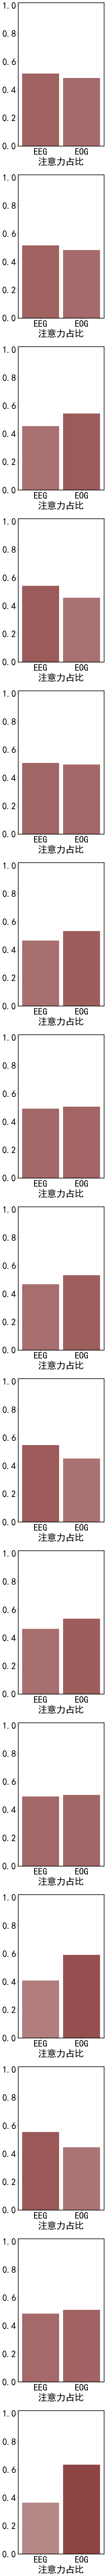

In [48]:
###### Interpreting cross-modal relationships  ##########
fig, axs = plt.subplots(15, 1, figsize = (1*5,15*10))

from matplotlib.font_manager import FontProperties
my_font = FontProperties(fname='env/simhei.ttf')

for i in range(num_seq):
  cross_features = feat_list[i][-1]  ##extracting learned cross-modal features
  cross_atten = atten_interpret(cross_features.squeeze()[0].unsqueeze(0),cross_features.squeeze()[1:]).squeeze().detach().cpu().numpy()
  
  rgba_colors = np.zeros((2,4))
  rgba_colors[:,0]=0.4 #value of red intensity divided by 256 
  rgba_colors[:,1]=0  #value of green intensity divided by 256
  rgba_colors[:,2]=0 #value of blue intensity divided by 256
  rgba_colors[:,-1]= cross_atten+0.1
  axs[i].bar(['EEG','EOG'], cross_atten,# color ='red',
          color =rgba_colors,align='center', width = 0.9)
  axs[i].tick_params(axis='x', labelsize=30)#,which = 'both')
  axs[i].tick_params(axis='y', labelsize=30)
  axs[i].set_ylim(0,1.02)
  axs[i].set_xlabel('注意力占比',fontsize = 30, fontproperties=my_font)

from datetime import datetime

# 创建文件名，包含当前日期时间
file_name = f"chart_{datetime.now().strftime('%Y%m%d%H%M%S')}.png"

save_path = f"output/{datetime.now().strftime('%Y%m%d%H%M')}/cross-modal relationships.jpg"
plt.savefig(save_path,dpi=300)



In [38]:
def plot_interpret(x,y,dydx,fig,axs_no,signal_type = "EEG"):


    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    # plt.figure(figsize = (30,5))
    # plt.figure(figsize=(25,5))
    # plt.plot(x,dydx)
    # plt.title(f"Attention Map for Class {label}  {signal_type} ")
    # plt.xlim(x.min(),x.max())
    # plt.colorbar()

    # fig, axs = plt.subplots(2, 1, sharex=True, sharey=True,figsize = (30,10))

    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(dydx.min(), dydx.max())
    lc = LineCollection(segments, cmap='Reds', norm=norm)
    # Set the values used for colormapping
    lc.set_array(dydx)
    lc.set_linewidth(15)
    line = axs[axs_no[0]][axs_no[1]].add_collection(lc)
    # fig.colorbar(line, ax=axs[axs_no[0]][axs_no[1]])
    # fig.colorbar(line, ax=axs[1])
    # axs[axs_no[0]][axs_no[1]].set_xlabel(f"{signal_type}",fontsize = 100,labelpad = 20)
    axs[axs_no[0]][axs_no[1]].set_title(f'Epoch {i+1} {signal_type}',fontsize = 100)
    # axs[i].set_xlabel('Signal',fontsize = 100)
    # axs[axs_no[0]][axs_no[1]].axis('off')
    # Hide X and Y axes label marks
    axs[axs_no[0]][axs_no[1]].xaxis.set_tick_params(labelbottom=False)
    axs[axs_no[0]][axs_no[1]].yaxis.set_tick_params(labelleft=False)

    # Hide X and Y axes tick marks
    axs[axs_no[0]][axs_no[1]].set_xticks([])
    axs[axs_no[0]][axs_no[1]].set_yticks([])
    axs[axs_no[0]][axs_no[1]].set_xlim(x.min(), x.max())
    axs[axs_no[0]][axs_no[1]].set_ylim(y.min()-0.2,y.max()+0.2)
    # show something
    # plt.show()

In [49]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
###### 解释同模态内部关系  ##########
plt.rcParams['axes.linewidth'] = 20
fig, axs = plt.subplots(15, 2, figsize = (2*50,15*20))
eeg_atten_list = [] #
eog_atten_list = [] #
# seq_features = feat_list[-1]
for i in range(num_seq):
  eeg_features = feat_list[i][0]     ##extracting learned intra-modal EEG features 
  eog_features = feat_list[i][1]    ##extracting learned intra-modal EOG features 
  cross_features = feat_list[i][-1]  ##extracting learned cross-modal features

  eeg_atten = atten_interpret(cross_features.squeeze()[0].unsqueeze(0),eeg_features.squeeze()[1:])#.squeeze().detach().cpu().numpy()
  eog_atten = atten_interpret(cross_features.squeeze()[0].unsqueeze(0),eog_features.squeeze()[1:])#.squeeze().detach().cpu().numpy()
  
  eeg_atten = F.upsample(eeg_atten.unsqueeze(0),scale_factor=3000//60, mode='nearest').squeeze().detach().cpu().numpy()
  eog_atten = F.upsample(eog_atten.unsqueeze(0),scale_factor=3000//60, mode='nearest').squeeze().detach().cpu().numpy()
  
  t1 = np.arange(0,30,1/100)
  plot_interpret(t1,eeg_data[t,0,i,:].squeeze().cpu().numpy(),eeg_atten,fig,[i,0],signal_type = "EEG")
  plot_interpret(t1,eog_data[t,0,i,:].squeeze().cpu().numpy(),eog_atten,fig,[i,1],signal_type = "EOG")

save_path = f"output/{datetime.now().strftime('%Y%m%d%H%M')}/同模态内部关系.jpg"
plt.savefig(save_path)


ValueError: Format 'int32)' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff, webp)

# Final plot similar to the paper

In [ ]:
# fig, axs = plt.subplots(num_seq, 4,figsize=(200, 20*num_seq),gridspec_kw={'width_ratios': [2,2,10,10]}) # for more clear figure
fig, axs = plt.subplots(num_seq, 4,figsize=(120, 20*num_seq),gridspec_kw={'width_ratios': [2,2,10,10]})
title_font_size = fig.dpi * 0.2
label_font_size = fig.dpi * 0.1
for i in range(num_seq):

        # Plotting inter-epoch attention ##############################
        rgba_colors = np.zeros((num_seq,4))
        rgba_colors[:,0]=0#value of red intensity divided by 256
        rgba_colors[i,0]=0.4#value of red intensity divided by 256
        rgba_colors[:,1]=0  #value of green intensity divided by 256
        rgba_colors[:,2]=0.4  #value of blue intensity divided by 256
        rgba_colors[i,2]=0
        rgba_colors[:,-1]= seq_atten_list[i]
        axs[i][0].bar(np.arange(1,num_seq+1), seq_atten_list[i]/seq_atten_list[i].max(),#/seq_attn[i].max(),# color ='blue',
                color =rgba_colors,align='center')
        # axs[i//5][i%5].set_title('')
        axs[i][0].tick_params(axis='x' ,labelsize=label_font_size)
        axs[i][0].tick_params(axis='y' ,labelsize=label_font_size)
        axs[i][0].set_xlabel('Epochs',fontsize = title_font_size)
        yticks = axs[i][0].yaxis.get_major_ticks()
        yticks[0].label1.set_visible(False)


        # Plotting cross-modal attention ##############################
        rgba_colors = np.zeros((2,4))
        rgba_colors[:,0]=0.4 #value of red intensity divided by 256
        rgba_colors[:,1]=0  #value of green intensity divided by 256
        rgba_colors[:,2]=0 #value of blue intensity divided by 256
        rgba_colors[:,-1]= cross_atten_list[i]
        axs[i][1].bar(['EEG','EOG'], cross_atten_list[i],# color ='red',
                color =rgba_colors,align='center')
        axs[i][1].tick_params(axis='x',labelsize=label_font_size)
        axs[i][1].tick_params(axis='y',labelsize=label_font_size)
        axs[i][1].set_ylim(0,1.02)
        axs[i][1].set_xlabel('Signal',fontsize = title_font_size)


        # # Plotting EEG attention ##############################
        eeg_atten_epoch = eeg_atten_list[i]
        t1 = np.arange(0,3000,1)
        plot_interpret(t1,eeg_data[t,0,i,:].squeeze().cpu().numpy(),eeg_atten,fig,[i,2],signal_type = f"EEG Class:{pred_list[i]}")

# plot_interpret(t1,eog_data[t,0,i,:].squeeze().cpu().numpy(),eog_atten,fig,[i,1],signal_type = "EOG")



        # # Plotting EOG attention ##############################
        eog_atten_epoch = eog_atten[i]
        plot_interpret(t1,eog_data[t,0,i,:].squeeze().cpu().numpy(),eog_atten,fig,[i,3],signal_type = f"EOG Class:{pred_list[i]}")

# time = [int(record_id.split('-')[1].split('_')[i]) for i in range(num_epoch_seq)]
# plt.subplots_adjust(wspace=0.2)
fig.suptitle('Interpretation for patient '+str(subject_no)+' for 30s epochs from '+str(start_time_point)+'s',fontsize = title_font_size*2)
plt.show()